In [1]:
%pip install susie==1.2.2 -q


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
# Importing from src imports directly from source code
from src.susie.timing_data import TimingData
from src.susie.ephemeris import Ephemeris, PrecessionModelEphemeris

import matplotlib.pyplot as plt

from lmfit import Model

In [3]:
# Can comment out which CSV file you'd like to use

# This is the REAL DATA for WASP-12 b pulled from Yee et al.
url = "https://raw.githubusercontent.com/BoiseStatePlanetary/susie/refs/heads/main/example_data/wasp12b_tra_occ.csv"

In [4]:
# Read the CSV file directly from the URL
data = pd.read_csv(url)
tra_or_occs = np.array(data["tra_or_occ"])
epochs = np.array(data["epoch"].astype('int'))
mid_times = np.array(data["mid_time"])
mid_time_errs = np.array(data["mid_time_err"])

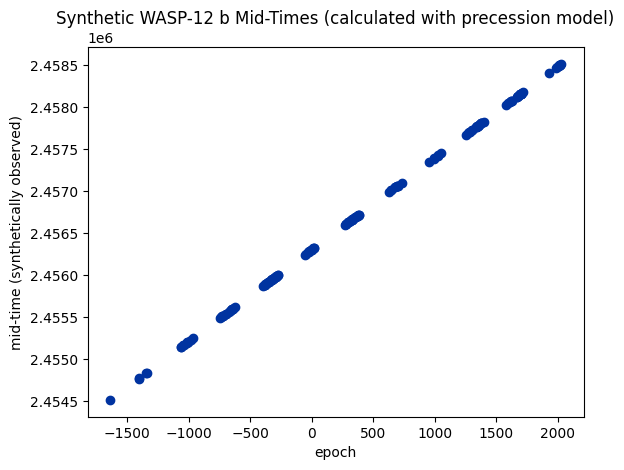

In [5]:
plt.scatter(epochs, mid_times, color="#0033A0")
plt.xlabel("epoch")
plt.ylabel("mid-time (synthetically observed)")
plt.title("Synthetic WASP-12 b Mid-Times (calculated with precession model)")
plt.show()

In [6]:
def calc_anomalistic_period(P, dwdE):
    """Anomalistic Period Calculation (P_a)"""
    return P/(1 - (1/(2*np.pi))*dwdE)

def calc_pericenter(w0, dwdE, E):
    """Pericenter Calculation (w(E))"""
    return w0 + dwdE*E

def subtract_linear_params(model_mid_times, T0, P, E, tra_or_occ):
    """Subtracting Linear Parameters From Given Mid-Times Function"""
    result = []
    for i, t_type in enumerate(tra_or_occ):
        if t_type == 'tra':
            # transit data
            result.append(model_mid_times[i] - T0 - (P*E[i]))
        elif t_type == 'occ':
            # occultation data
            result.append(model_mid_times[i] - T0 - (0.5*P) - (P*E[i]))
    return np.array(result)

def plot_model_ephemeris(ephemeris_obj, model_data_dict, subtract_lin_params=False, show_occultations=False):
    """Plot Model Ephemeris Function"""
    fig, ax = plt.subplots(figsize=(6, 6))
    y_data = model_data_dict['model_data']
    if subtract_lin_params is True:
        y_data = subtract_linear_params(model_data_dict['model_data'], model_data_dict['conjunction_time'], model_data_dict['period'], ephemeris_obj.timing_data.epochs, ephemeris_obj.timing_data.tra_or_occ) * 86400
    ax.scatter(x=ephemeris_obj.timing_data.epochs, y=y_data, color='#0033A0', zorder=10, label="Transits")
    if show_occultations is True:
        occ_mask = ephemeris_obj.timing_data.tra_or_occ == "occ"
        occ_data = model_data_dict["model_data"][occ_mask]
        if subtract_lin_params is True:
            occ_data = subtract_linear_params(occ_data, model_data_dict['conjunction_time'], model_data_dict['period'], ephemeris_obj.timing_data.epochs[occ_mask], ephemeris_obj.timing_data.tra_or_occ[occ_mask]) * 86400
        ax.scatter(x=ephemeris_obj.timing_data.epochs[occ_mask], y=occ_data, color="#D64309", zorder=20, label="Occultations")
        ax.legend()
    ax.set_xlabel('Epochs')
    ax.set_ylabel('Mid-Times (JD TDB)')
    ax.set_title(f'{model_data_dict["model_type"].capitalize()} Model Ephemeris Mid-Times')
    ax.grid(linestyle='--', linewidth=0.25, zorder=-1)
    ax.ticklabel_format(style="plain", useOffset=False)
    return ax

def plot_oc_plot(ephemeris_obj, model, T0, P):
    """O-C Plot Function"""
    fig, ax = plt.subplots()
    DAYS_TO_SECONDS = 86400
    model_data = ephemeris_obj.get_model_ephemeris(model)
    y = (subtract_linear_params(ephemeris_obj.timing_data.mid_times, T0, P, ephemeris_obj.timing_data.epochs, ephemeris_obj.timing_data.tra_or_occ)) * DAYS_TO_SECONDS
    ax.errorbar(ephemeris_obj.timing_data.epochs, y, yerr=ephemeris_obj.timing_data.mid_time_uncertainties*DAYS_TO_SECONDS, 
                marker='o', ls='', color='#0033A0',
                label=r'$t(E) - T_0 - P E$')
    
    if model == "quadratic":
        # Plot additional quadratic curve
        quad_model_curve = (0.5*model_data['period_change_by_epoch'])*((ephemeris_obj.timing_data.epochs - np.median(ephemeris_obj.timing_data.epochs))**2) * DAYS_TO_SECONDS
        ax.plot(ephemeris_obj.timing_data.epochs,
                (quad_model_curve),
                color='#D64309', ls="--", label=r'$\frac{1}{2}(\frac{dP}{dE})E^2$')
    
    if model == "precession":
        # Plot additional precession curves
        tra_mask = ephemeris_obj.timing_data.tra_or_occ == "tra"
        occ_mask = ephemeris_obj.timing_data.tra_or_occ == "occ"
        # tra curve = -1 * (e*P_a)/(pi) * cos(w(E))
        # occ curve = (e*P_a)/(pi) * cos(w(E))
        precession_model_curve_tra = (-1 * ((model_data["eccentricity"]*calc_anomalistic_period(P, model_data["pericenter_change_by_epoch"]))/np.pi) * np.cos(calc_pericenter(model_data["pericenter"], model_data["pericenter_change_by_epoch"], (ephemeris_obj.timing_data.epochs[tra_mask] - np.median(ephemeris_obj.timing_data.epochs[tra_mask]))))) * DAYS_TO_SECONDS
        precession_model_curve_occ = (((model_data["eccentricity"]*calc_anomalistic_period(P, model_data["pericenter_change_by_epoch"]))/np.pi) * np.cos(calc_pericenter(model_data["pericenter"], model_data["pericenter_change_by_epoch"], (ephemeris_obj.timing_data.epochs[occ_mask] - np.median(ephemeris_obj.timing_data.epochs[occ_mask]))))) * DAYS_TO_SECONDS
        ax.plot(ephemeris_obj.timing_data.epochs[tra_mask],
                (precession_model_curve_tra),
                color='#D64309', ls="--", label=r'$-\frac{eP_a}{\pi}\cos\omega(E)$')
        ax.plot(ephemeris_obj.timing_data.epochs[occ_mask],
                (precession_model_curve_occ),
                color='#D64309', ls=":", label=r'$\frac{eP_a}{\pi}\cos\omega(E)$')
    
    ax.legend()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('O-C (seconds)')
    ax.set_title('Observed Minus Calculated Mid-Times')
    ax.grid(linestyle='--', linewidth=0.25, zorder=-1)
    return ax

In [7]:
# Create new transit times object with above data
timing_obj = TimingData('jd', epochs, mid_times, mid_time_uncertainties=mid_time_errs, tra_or_occ=tra_or_occs, time_scale='tdb')
ephemeris_obj = Ephemeris(timing_obj)

In [17]:
lin_model = ephemeris_obj.get_model_ephemeris("linear")

In [14]:
quad_model = ephemeris_obj.get_model_ephemeris("quadratic")

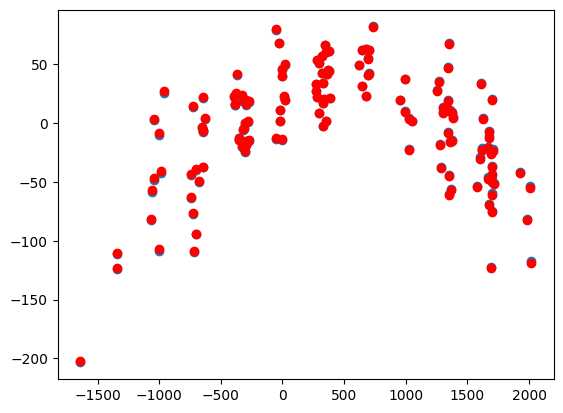

In [28]:
tra_mask = tra_or_occs == 'tra'
plt.scatter(epochs[tra_mask], (mid_times[tra_mask] - (lin_model["conjunction_time"] + lin_model["period"]*epochs[tra_mask]))*24*60*60)
plt.scatter(epochs[tra_mask], (mid_times[tra_mask] - (2456305.455521 + 1.091419649*epochs[tra_mask]))*24*60*60, color="red")

In [36]:
tra_mask = tra_or_occs == 'tra'
occ_mask = tra_or_occs == 'occ'
plt.scatter(epochs[occ_mask], (mid_times[occ_mask] - (lin_model["conjunction_time"] + (lin_model["period"]/2) + (lin_model["period"]*epochs[occ_mask])))*24*60*60, label=r"$t_E - (t0_{lin}^{Susie} + \frac{P_{lin}^{Susie}}{2} + P_{lin}^{Susie}E)$")
plt.scatter(epochs[occ_mask], (mid_times[occ_mask] - (2456305.455521 + (1.091419649/2) + (1.091419649*epochs[occ_mask])))*24*60*60, label=r"$t_E - (t0_{lin}^{Yee+} + \frac{P_{lin}^{Yee+}}{2} + P_{lin}^{Yee+}E)$")

plt.scatter(epochs[tra_mask], (mid_times[tra_mask] - (lin_model["conjunction_time"] + lin_model["period"]*epochs[tra_mask]))*24*60*60, label="Transits (subtracting Susie lin model)")
plt.scatter(epochs[tra_mask], (mid_times[tra_mask] - (2456305.455521 + 1.091419649*epochs[tra_mask]))*24*60*60, color="red", label="Transits (subtracting Yee+ lin model)")

plt.xlabel("Epoch")
plt.ylabel("")
plt.legend()


SyntaxError: invalid syntax (1988740348.py, line 4)

In [8]:
quadratic_model_data = ephemeris_obj.get_model_ephemeris("quadratic")

<Axes: title={'center': 'Observed Minus Calculated Mid-Times'}, xlabel='Epoch', ylabel='O-C (seconds)'>

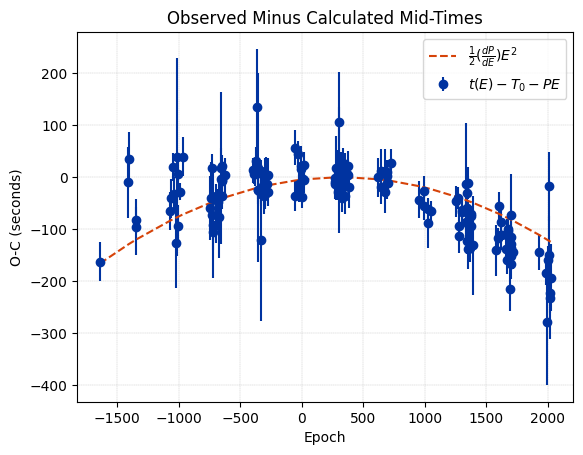

In [25]:
ephemeris_obj.plot_oc_plot("quadratic")

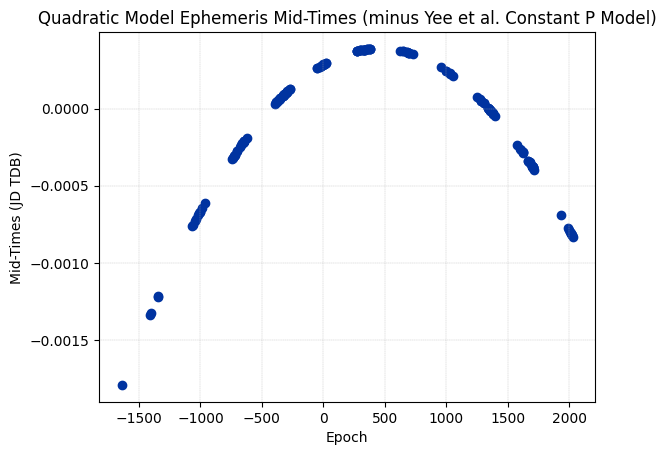

In [9]:
quad_model_subtracted_params = subtract_linear_params(quadratic_model_data["model_data"], 2456305.455521, 1.091419649, ephemeris_obj.timing_data.epochs, ephemeris_obj.timing_data.tra_or_occ)
plt.scatter(epochs, quad_model_subtracted_params, color="#0033A0")
plt.xlabel("Epoch")
plt.ylabel("Mid-Times (JD TDB)")
plt.title("Quadratic Model Ephemeris Mid-Times (minus Yee et al. Constant P Model)")
plt.grid(linestyle='--', linewidth=0.25, zorder=-1)
plt.show()

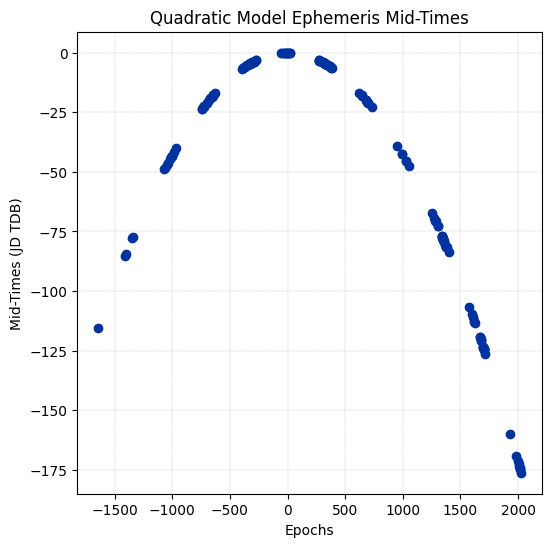

In [10]:
plot_model_ephemeris(ephemeris_obj, quadratic_model_data, subtract_lin_params=True)
plt.show()